This notebook is a fork of

- [Vitaly Kudelya](https://www.kaggle.com/vitalykudelya): [NeurIPS - Ariel Data Correlation Parallel + Scale](https://www.kaggle.com/code/vitalykudelya/neurips-ariel-data-correlation-parallel-scale)

**The idea**: we can scale not only the **s** values, but the corresponding **sigma** values as well (using the same prior distribution *wave_to_apriori_scale*). 

This notebook builds upon the excellent work done in the following baselines: <br />
- [Sergei Fironov](https://www.kaggle.com/sergeifironov): [ariel_only_correlation](https://www.kaggle.com/code/sergeifironov/ariel-only-correlation)
- [Laurent Pourchot](https://www.kaggle.com/pourchot): [Ariel Data Challenge 2024](https://www.kaggle.com/code/pourchot/ariel-data-challenge-2024?scriptVersionId=195970765)
- [qianc](https://www.kaggle.com/xiaocao123): [Ariel Data Challenge 2024](https://www.kaggle.com/code/xiaocao123/ariel-data-challenge-2024)

Thank you to the authors for sharing their insights and code 🙏



## Granularity
Granularity of predictions is one planet.
For each planet we need to predict `283` `spectras` (float number) for corresponding wave lengths and each with an associated uncertainty `sigma`.

## Data
For each planet we have:
- **FGS1** signal (`FGS1_signal.parquet`) `[135000, 32, 32]` (`135000` time steps, each representing `0.1` seconds and `32*32` is sensor data) 
- **AIRS-CH0** signal (`AIRS-CH0_signal.parquet`) `[11250, 32, 356]` (`11250` time steps, each representing `1.2` seconds and `32*356` is sensor data `32` spatial and `356` different wave lengths)

Also we have additional calibration data to make raw data from sensors more informative.

## Baseline overview
    
### Preprocessing
* Calibration of raw signal. It consists of scaling the signal, eliminating dead pixels and other complicated techniques [calibration discussion](https://www.kaggle.com/competitions/ariel-data-challenge-2024/discussion/528066). Only `40-321` wave_length positions (they should relate to `2-283` positions in targets) are taken for **AIRS-CH0**
* Calibrated signal is divided into time chunks and aggregated (mean). It reduces number of time points and we get
  `[187, 32, 32]` for **FGS1** (`187` time steps) and `[187, 32, 282]` for **AIRS-CH0** (`187` time steps)
* Only center spatial pixels are taken and get `[187, 12, 12]` for **FGS1** and `[187, 12, 282]` for **AIRS-CH0**
* Aggregate (mean) sensor data per special dimension. We get `[187, 1]` for **FGS1** and `[187, 282]` for **AIRS-CH0**
* Concatenate **FGS1** and **AIRS-CH0** to `[187, 283]` array. Let's call it a `preprocessed_signal`

### Spectra prediction
* Aggregate (mean) of our `preprocessed_signal` for `2-283` wave_length positions and get `[187]` data points (time dimension) as an input to further optimizations
* Find time points `phase1` and `phase2` - start and end of planet going in front of the star (`phase_detector`)
* Next we need to find a constant `s` (actually our further prediction of `spectra`) that after multiplication
`signal[phase1:phase2] * (1 + s)` we can't see a "step" in the signal (more formally, the error after fitting 3nd power polynomial is minimal)

An exmaple for planet signal phases is demonstrated at the image
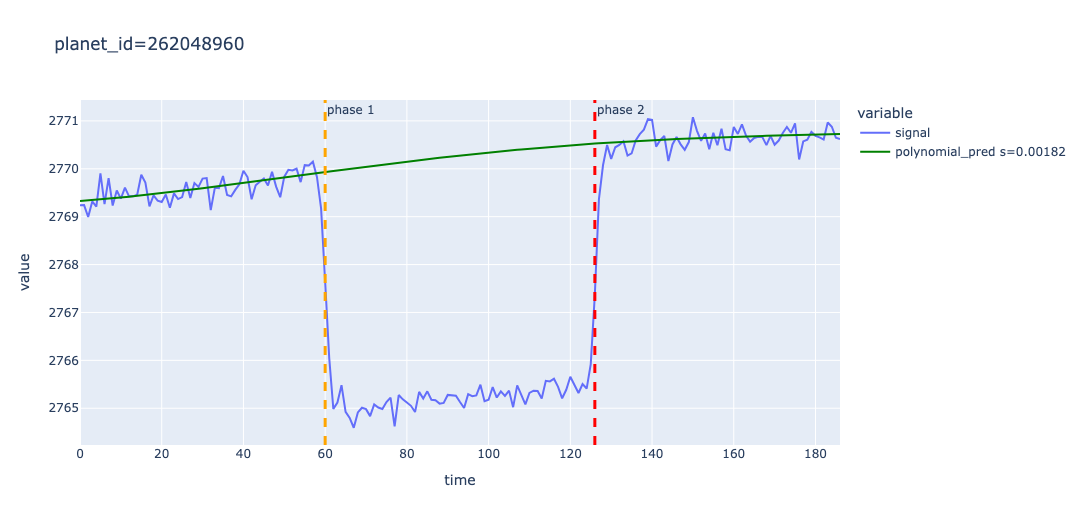
* We just predict the same `s` for all different spectras (`283`)
* Sigma is just a constant `0.000145` for all spectras and all planets




## Updates
* Paralllel preprocessing of planet's raw data with `pqdm` (the library for parallel and interactive bar computations similar to `tqdm`). It made preprocessing x2.2 faster on my tests
* It was added a simple multiplication of `spectra` predicitons for different wavelength based on it under or over predictions on average for train data
* A little refactoring



In [1]:
!pip install --no-index --find-links=/kaggle/input/ariel-2024-pqdm pqdm

Looking in links: /kaggle/input/ariel-2024-pqdm
Processing /kaggle/input/ariel-2024-pqdm/pqdm-0.2.0-py2.py3-none-any.whl
Processing /kaggle/input/ariel-2024-pqdm/bounded_pool_executor-0.0.3-py3-none-any.whl (from pqdm)


# Librairies

In [2]:
import pandas as pd
import numpy as np
import pandas.api.types
import scipy.stats

from tqdm import tqdm
from pqdm.processes import pqdm

import itertools

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import plotly.express as px

from astropy.stats import sigma_clip


# Signal Preprocessing

In [3]:
class Calibrator:
    cut_inf = 39
    cut_sup = 321
    sensor_to_sizes_dict = {
        "AIRS-CH0": [[11250, 32, 356], [1, 32, cut_sup - cut_inf]],
        "FGS1": [[135000, 32, 32], [1, 32, 32]],
    }
    sensor_to_linear_corr_dict = {"AIRS-CH0": (6, 32, 356), "FGS1": (6, 32, 32)}

    def __init__(self, dataset, planet_id, sensor):
        self.dataset = dataset
        self.planet_id = planet_id
        self.sensor = sensor

    def _apply_linear_corr(self, linear_corr, clean_signal):
        linear_corr = np.flip(linear_corr, axis=0)
        for x, y in itertools.product(
            range(clean_signal.shape[1]), range(clean_signal.shape[2])
        ):
            poli = np.poly1d(linear_corr[:, x, y])
            clean_signal[:, x, y] = poli(clean_signal[:, x, y])
        return clean_signal

    def _clean_dark(self, signal, dark, dt):
        dark = np.tile(dark, (signal.shape[0], 1, 1))
        signal -= dark * dt[:, np.newaxis, np.newaxis]
        return signal

    def get_calibrated_signal(self):
        signal = pd.read_parquet(
            f"/kaggle/input/ariel-data-challenge-2024/{self.dataset}/{self.planet_id}/{self.sensor}_signal.parquet"
        ).to_numpy()
        dark_frame = pd.read_parquet(
            f"/kaggle/input/ariel-data-challenge-2024/{self.dataset}/{self.planet_id}/{self.sensor}_calibration/dark.parquet",
            engine="pyarrow",
        ).to_numpy()
        dead_frame = pd.read_parquet(
            f"/kaggle/input/ariel-data-challenge-2024/{self.dataset}/{self.planet_id}/{self.sensor}_calibration/dead.parquet",
            engine="pyarrow",
        ).to_numpy()
        flat_frame = pd.read_parquet(
            f"/kaggle/input/ariel-data-challenge-2024/{self.dataset}/{self.planet_id}/{self.sensor}_calibration/flat.parquet",
            engine="pyarrow",
        ).to_numpy()
        linear_corr = (
            pd.read_parquet(
                f"/kaggle/input/ariel-data-challenge-2024/{self.dataset}/{self.planet_id}/{self.sensor}_calibration/linear_corr.parquet"
            )
            .values.astype(np.float64)
            .reshape(self.sensor_to_linear_corr_dict[self.sensor])
        )

        signal = signal.reshape(self.sensor_to_sizes_dict[self.sensor][0])
        gain = adc_info.loc[self.planet_id, f"{self.sensor}_adc_gain"]
        offset = adc_info.loc[self.planet_id, f"{self.sensor}_adc_offset"]
        signal = signal / gain + offset

        hot = sigma_clip(dark_frame, sigma=5, maxiters=5).mask

        if self.sensor == "AIRS-CH0":
            signal = signal[:, :, self.cut_inf : self.cut_sup]
            dt = np.ones(len(signal)) * 0.1
            dt[1::2] += 4.5  # @bilzard idea
            linear_corr = linear_corr[:, :, self.cut_inf : self.cut_sup]
            dark_frame = dark_frame[:, self.cut_inf : self.cut_sup]
            dead_frame = dead_frame[:, self.cut_inf : self.cut_sup]
            flat_frame = flat_frame[:, self.cut_inf : self.cut_sup]
            hot = hot[:, self.cut_inf : self.cut_sup]
        elif self.sensor == "FGS1":
            dt = np.ones(len(signal)) * 0.1
            dt[1::2] += 0.1

        signal = signal.clip(0)  # @graySnow idea
        linear_corr_signal = self._apply_linear_corr(linear_corr, signal)
        signal = self._clean_dark(linear_corr_signal, dark_frame, dt)

        flat = flat_frame.reshape(self.sensor_to_sizes_dict[self.sensor][1])
        flat[dead_frame.reshape(self.sensor_to_sizes_dict[self.sensor][1])] = np.nan
        flat[hot.reshape(self.sensor_to_sizes_dict[self.sensor][1])] = np.nan
        signal = signal / flat
        return signal


class Preprocessor:
    sensor_to_binning = {"AIRS-CH0": 30, "FGS1": 30 * 12}
    sensor_to_binned_dict = {
        "AIRS-CH0": [11250 // sensor_to_binning["AIRS-CH0"] // 2, 282],
        "FGS1": [135000 // sensor_to_binning["FGS1"] // 2],
    }

    def __init__(self, dataset, planet_id, sensor):
        self.dataset = dataset
        self.planet_id = planet_id
        self.sensor = sensor
        self.binning = self.sensor_to_binning[sensor]

    def preprocess_signal(self):
        signal = Calibrator(
            dataset=self.dataset, planet_id=self.planet_id, sensor=self.sensor
        ).get_calibrated_signal()

        if self.sensor == "AIRS-CH0":
            signal = signal[:, 10:22, :]
        elif self.sensor == "FGS1":
            signal = signal[:, 10:22, 10:22]
            signal = signal.reshape(
                signal.shape[0], signal.shape[1] * signal.shape[2]
            )

        mean_signal = np.nanmean(signal, axis=1)
        cds_signal = mean_signal[1::2] - mean_signal[0::2]

        binned = np.zeros((self.sensor_to_binned_dict[self.sensor]))
        for j in range(cds_signal.shape[0] // self.binning):
            binned[j] = cds_signal[
                j * self.binning : j * self.binning + self.binning
            ].mean(axis=0)

        if self.sensor == "FGS1":
            binned = binned.reshape((binned.shape[0], 1))

        return binned


def preprocessor(x):
    return Preprocessor(**x).preprocess_signal()


In [4]:
dataset = "test"
adc_info = pd.read_csv(
    "/kaggle/input/ariel-data-challenge-2024/" + f"{dataset}_adc_info.csv",
    index_col="planet_id",
)
axis_info = pd.read_parquet("/kaggle/input/ariel-data-challenge-2024/axis_info.parquet")
planet_ids = adc_info.index

In [5]:
args_fgs1 = [
    dict(dataset=dataset, planet_id=planet_id, sensor="FGS1")
    for planet_id in planet_ids
]
preprocessed_signal_fgs1 = pqdm(args_fgs1, preprocessor, n_jobs=4)

args_airs_ch0 = [
    dict(dataset=dataset, planet_id=planet_id, sensor="AIRS-CH0")
    for planet_id in planet_ids
]
preprocessed_signal_airs_ch0 = pqdm(args_airs_ch0, preprocessor, n_jobs=4)

preprocessed_signal = np.concatenate(
    [np.stack(preprocessed_signal_fgs1), np.stack(preprocessed_signal_airs_ch0)], axis=2
)
preprocessed_signal.shape

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

(1, 187, 283)

# Modelization

In [6]:
def phase_detector(signal):
    MIN = np.argmin(signal[30:140]) + 30
    signal1 = signal[:MIN]
    signal2 = signal[MIN:]

    first_derivative1 = np.gradient(signal1)
    first_derivative1 /= first_derivative1.max()
    first_derivative2 = np.gradient(signal2)
    first_derivative2 /= first_derivative2.max()

    phase1 = np.argmin(first_derivative1)
    phase2 = np.argmax(first_derivative2) + MIN

    return phase1, phase2


def predict_spectra(signal):
    def objective_to_minimize(s):
        delta = 2
        power = 3
        x = list(range(signal.shape[0] - delta * 4))
        y = (
            signal[: phase1 - delta].tolist()
            + (signal[phase1 + delta : phase2 - delta] * (1 + s)).tolist()
            + signal[phase2 + delta :].tolist()
        )

        z = np.polyfit(x, y, deg=power)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        return q

    signal = signal[:, 1:].mean(axis=1)
    phase1, phase2 = phase_detector(signal)

    s = minimize(fun=objective_to_minimize, x0=[0.0001], method="Nelder-Mead").x[0]
    return s


predictions_spectra = [
    predict_spectra(preprocessed_signal[i]) for i in range(len(preprocessed_signal))
]

# A priori scales

In [7]:
# TO REDUCE EXECUTION TIME, CODE IS COMMENTED AND RESULT IS LOADED FROM PRECOMPUTED

# dataset = "train"
# adc_info = pd.read_csv(
#     "/kaggle/input/ariel-data-challenge-2024/" + f"{dataset}_adc_info.csv",
#     index_col="planet_id",
# )
# axis_info = pd.read_parquet("/kaggle/input/ariel-data-challenge-2024/axis_info.parquet")
# planet_ids = adc_info.index

# df_train_labels = pd.read_csv(
#     "/kaggle/input/ariel-data-challenge-2024/train_labels.csv", index_col="planet_id"
# )

# args_fgs1 = [
#     dict(dataset=dataset, planet_id=planet_id, sensor="FGS1")
#     for planet_id in planet_ids
# ]
# preprocessed_signal_fgs1 = pqdm(args_fgs1, preprocessor, n_jobs=4)

# args_airs_ch0 = [
#     dict(dataset=dataset, planet_id=planet_id, sensor="AIRS-CH0")
#     for planet_id in planet_ids
# ]
# preprocessed_signal_airs_ch0 = pqdm(args_airs_ch0, preprocessor, n_jobs=4)

# preprocessed_signal = np.concatenate(
#     [np.stack(preprocessed_signal_fgs1), np.stack(preprocessed_signal_airs_ch0)], axis=2
# )

# predictions_spectra_train = np.array(
#     [predict_spectra(preprocessed_signal[i]) for i in range(len(preprocessed_signal))]
# )

# wave_to_apriori_scale = {}
# for wave in tqdm(df_train_labels.columns):
#     scale = (df_train_labels[wave] / predictions_spectra_train).mean()
#     wave_to_apriori_scale[wave] = scale

wave_to_apriori_scale = pd.read_pickle(
    "/kaggle/input/ariel-2024-pqdm/wave_to_apriori_scale.pkl"
)

In [8]:
fig = px.line(
    x=range(1, 283 + 1),
    y=wave_to_apriori_scale.values(),
    title=f"wave_to_apriori_scale train",
)
fig.update_layout(xaxis_title="wave_number", yaxis_title="scale")
fig.show()

# Submission

In [9]:
sample_submission = pd.read_csv(
    "/kaggle/input/ariel-data-challenge-2024/sample_submission.csv",
    index_col="planet_id",
)

predictions_spectra = np.repeat(np.array(predictions_spectra), 283).reshape(
    (len(predictions_spectra), 283)
)
predictions_spectra = predictions_spectra.clip(0)

sigmas = np.ones_like(predictions_spectra) * 0.000145

submission = pd.DataFrame(
    np.concatenate([predictions_spectra, sigmas], axis=1),
    columns=sample_submission.columns,
)
submission.index = sample_submission.index

In [10]:
for wave, scale in wave_to_apriori_scale.items():
    # scale s
    if 0.99 < scale < 1.01:
        scale = 1.0
    if wave in ['wl_2']:
        scale = 0.99
    if wave in ['wl_133', 'wl_134']:
        scale = 1.01
    scale = np.clip(scale, 0.993, 1.007)
    submission[wave] *= scale

    # scale sigma
    wl_idx = wave.split('_')[-1]
    scale = 1.0 + 28.0 * (scale - 1.0)
    assert 1 <= int(wl_idx) <= 283
    submission['sigma_' + wl_idx] *= scale

In [11]:
submission.to_csv("submission.csv")
submission

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
499191466,0.002706,0.002706,0.002706,0.002706,0.002706,0.002706,0.002706,0.002706,0.002706,0.002706,...,0.000117,0.000117,0.000117,0.000117,0.000117,0.000117,0.000117,0.000117,0.000117,0.000117
